# Unraveling Gravitational Ripples: Neural Network Classification
### GASF vs FFT vs QTransform with New Data
### **GWGASF Members:** $Daniel\;Fredin^{1,2}$, $Cole\;Welch^{1,3}$, $Chia-Jui\;Chou^{4}$, $Andy\;Chen^{4}$, & $Shih-Chieh\;Hsu^{1}$
#### $^{1}University\;of\;Washington,\;Seattle\;USA$; $^{2}University\;of\;Massachusetts\;Lowell,\;Lowell\;USA$;$^{3}Georgia\;Institute\;of\;Technology,\;Atlanta\;USA$; $^{4}National\;Yang\;Ming\;Chiao\;Tung\;University,\;Hsinchu\;City,\;TW$

--------------------

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import torch
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch import nn
from pyts.image import GramianAngularField
from tqdm import tqdm


from gasf.utils import h5_thang
import random
# from gasf.sampling import *
# import ml4gw

## Old packages that are not currently used ##
# import pandas as pd
# import seaborn as sns
# from scipy import signal
# from gwpy.timeseries import TimeSeries
# from gwpy.signal import filter_design
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
# from timeit import default_timer as timer

# from tqdm.notebook import trange

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Preparing the data

### TESTING New Data

In [3]:
# Loading datafiles and only load a slice of the total data.
numSamples = 2500 # from each glitch/signal/background

# bbh signals
bbh_signals_filename = '/home/dfredin/gwgasf/data/5_2_2024/bbh_dataset_p1.hdf5'
bbh_info = h5_thang(bbh_signals_filename)
bbh_keys = bbh_info.h5_keys()
H1_bbh = bbh_info.h5_data()['H1'][0:numSamples]
L1_bbh = bbh_info.h5_data()['L1'][0:numSamples]

# H1 background
H1_bg_filename = '/home/dfredin/gwgasf/data/5_2_2024/H1_bg_dataset_p1.hdf5'
H1_bg_info = h5_thang(H1_bg_filename)
H1_bg_keys = H1_bg_info.h5_keys()
H1_bg = H1_bg_info.h5_data()['background_noise'][0:numSamples]
# L1 background
L1_bg_filename = '/home/dfredin/gwgasf/data/5_2_2024/L1_bg_dataset_p1.hdf5'
L1_bg_info = h5_thang(L1_bg_filename)
L1_bg_keys = L1_bg_info.h5_keys()
L1_bg = L1_bg_info.h5_data()['background_noise'][0:numSamples]

# H1 glitch
H1_glitch_filename = '/home/dfredin/gwgasf/data/5_2_2024/H1_glitch_dataset_p1.hdf5'
H1_glitch_info = h5_thang(H1_glitch_filename)
H1_glitch_keys = H1_glitch_info.h5_keys()
H1_glitch = H1_glitch_info.h5_data()['glitch'][0:numSamples]
# L1 glitch
L1_glitch_filename = '/home/dfredin/gwgasf/data/5_2_2024/L1_glitch_dataset_p1.hdf5'
L1_glitch_info = h5_thang(L1_glitch_filename)
L1_glitch_keys = L1_glitch_info.h5_keys()
L1_glitch = L1_glitch_info.h5_data()['glitch'][0:numSamples]


# # hfsg signals
# hfsg_signals_filename = '/home/dfredin/gwgasf/data/5_2_2024/hfsg_dataset_p1.hdf5'
# hfsg_info = h5_thang(hfsg_signals_filename)
# hfsg_keys = hfsg_info.h5_keys()
# H1_hfsg = hfsg_info.h5_data()['H1'][0:numSamples]
# L1_hfsg = hfsg_info.h5_data()['L1'][0:numSamples]
# # lfsg signals
# lfsg_signals_filename = '/home/dfredin/gwgasf/data/5_2_2024/lfsg_dataset_p1.hdf5'
# lfsg_info = h5_thang(lfsg_signals_filename)
# lfsg_keys = lfsg_info.h5_keys()
# H1_lfsg = lfsg_info.h5_data()['H1'][0:numSamples]
# L1_lfsg = lfsg_info.h5_data()['L1'][0:numSamples]

# variables = [H1_bbh, L1_bbh, H1_bg, H1_glitch, L1_bg, L1_glitch, H1_hfsg, L1_hfsg, H1_lfsg, L1_lfsg]
# names = ['H1 BBH', 'L1 BBH', 'H1 BG', 'H1 Glitch', 'L1 BG', 'L1 Glitch', 'H1 HFSG', 'L1 HFSG', 'H1 LFSG', 'L1 LFSG']

# for name, var in zip(names, variables):
#     print(f"{name} Shape: {var.shape}")

variables = [H1_bbh, L1_bbh, H1_bg, H1_glitch, L1_bg, L1_glitch]
names = ['H1 BBH', 'L1 BBH', 'H1 BG', 'H1 Glitch', 'L1 BG', 'L1 Glitch']

for name, var in zip(names, variables):
    print(f"{name} Shape: {var.shape}")

H1 BBH Shape: (2500, 24576)
L1 BBH Shape: (2500, 24576)
H1 BG Shape: (2500, 24576)
H1 Glitch Shape: (2500, 24576)
L1 BG Shape: (2500, 24576)
L1 Glitch Shape: (2500, 24576)


In [4]:
H1_glitch_snr = H1_glitch_info.h5_data()['glitch_info']
L1_glitch_snr = L1_glitch_info.h5_data()['glitch_info']

h1_indices = np.where(H1_glitch_snr['snr'] >= 15)
H1_glitch_snr_high = H1_glitch_info.h5_data()['glitch'][h1_indices]

l1_indices = np.where(L1_glitch_snr['snr'] >= 15)
L1_glitch_snr_high = L1_glitch_info.h5_data()['glitch'][l1_indices]


H1_glitch_snr_high = H1_glitch_snr_high[0:len(L1_glitch_snr_high)]
glitch_highsnr_signals = np.dstack((H1_glitch_snr_high, L1_glitch_snr_high))
glitch_signals = glitch_highsnr_signals

In [5]:
del L1_glitch_snr_high, H1_glitch_snr_high, H1_glitch_snr, L1_glitch_snr, glitch_highsnr_signals

In [6]:
## Stacking the arrays for the H1 and L1 detectors

bbh_signals = np.dstack((H1_bbh, L1_bbh))
bg_signals = np.dstack((H1_bg, L1_bg))
# glitch_signals = np.dstack((H1_glitch, L1_glitch))
# hfsg_signals = np.dstack((H1_hfsg, L1_hfsg))
# lfsg_signals = np.dstack((H1_lfsg, L1_lfsg))

del H1_bbh, L1_bbh, H1_bg, L1_bg, H1_glitch, L1_glitch

# variables = [bbh_signals, bg_signals, glitch_signals, hfsg_signals, lfsg_signals]
# names = ['BBH Signals', 'BG Signals', 'Glitch Signals', 'HFSG Signals', 'LFSG Signals']

# for name, var in zip(names, variables):
#     print(f"{name} Shape: {var.shape}")

x_train = np.concatenate((glitch_signals, bbh_signals, bg_signals))
x_train.shape

(5189, 24576, 2)

In [7]:
## ---------------- ONE-HOT ENCODING ----------------------------##

# NOTE: 
# Multiclassifier
anomaly_class = {
    'Glitch': [1, 0, 0],
    'Signal': [0, 1, 0],
    'Background': [0, 0, 1]
}

glitch_train_ids = np.full((glitch_signals.shape[0], 3), anomaly_class['Glitch'])
bbh_train_ids = np.full((bbh_signals.shape[0], 3), anomaly_class['Signal'])
bg_train_ids = np.full((bg_signals.shape[0], 3), anomaly_class['Background'])


y_train_ids = np.concatenate((glitch_train_ids, bbh_train_ids, bg_train_ids), axis=0)
del bbh_signals, bg_signals, glitch_signals
del glitch_train_ids, bbh_train_ids, bg_train_ids

In [8]:
n_train = 2000

# Generate the idx_train, idx_val to randomly sample from the training set and validation set.
idx_train = np.random.randint(0, len(x_train), size=n_train)

y_train = y_train_ids[idx_train]

### -------------GASF CONVERSION------------- ###

GASF = GramianAngularField(image_size=194, sample_range = (-1,1), method="summation")
# Convert training data to image format
img_x_train_dec1 = GASF.transform(x_train[idx_train,:,0])
img_x_train_dec2 = GASF.transform(x_train[idx_train,:,1])

img_x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
del img_x_train_dec1, img_x_train_dec2


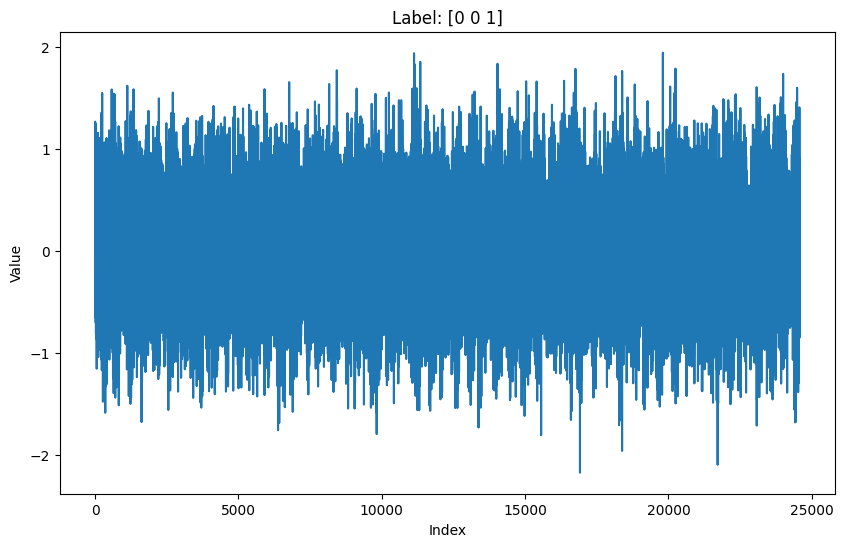

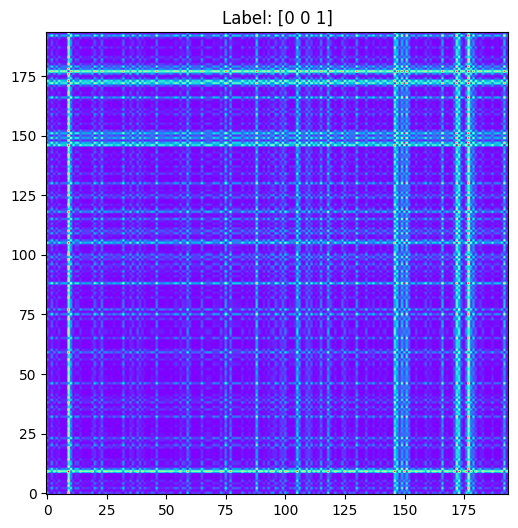

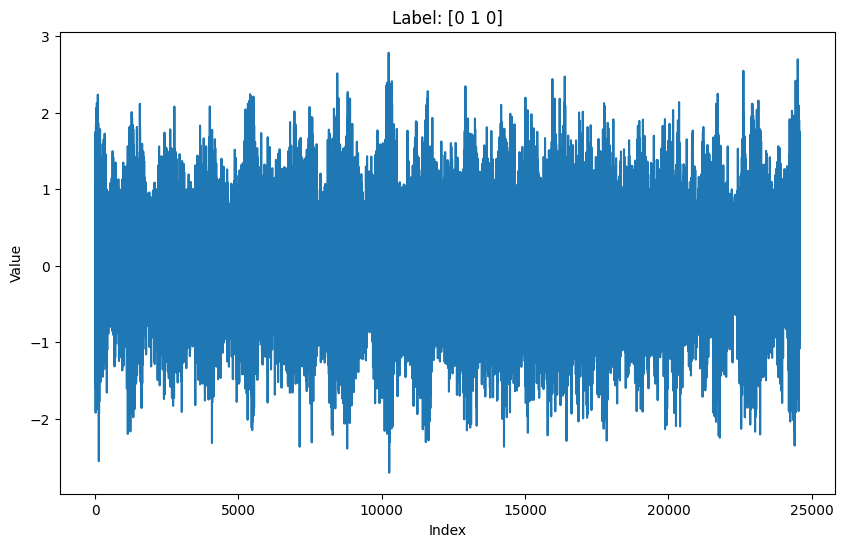

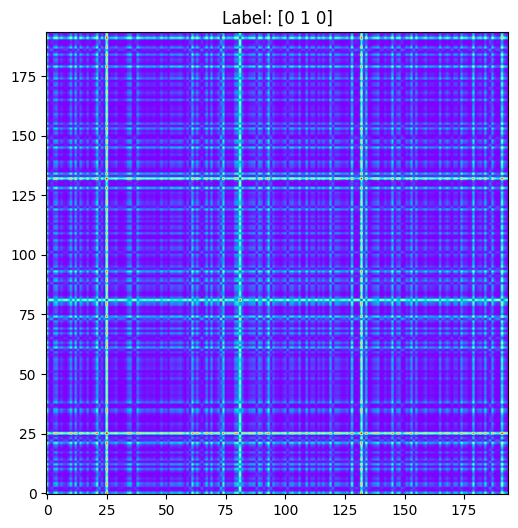

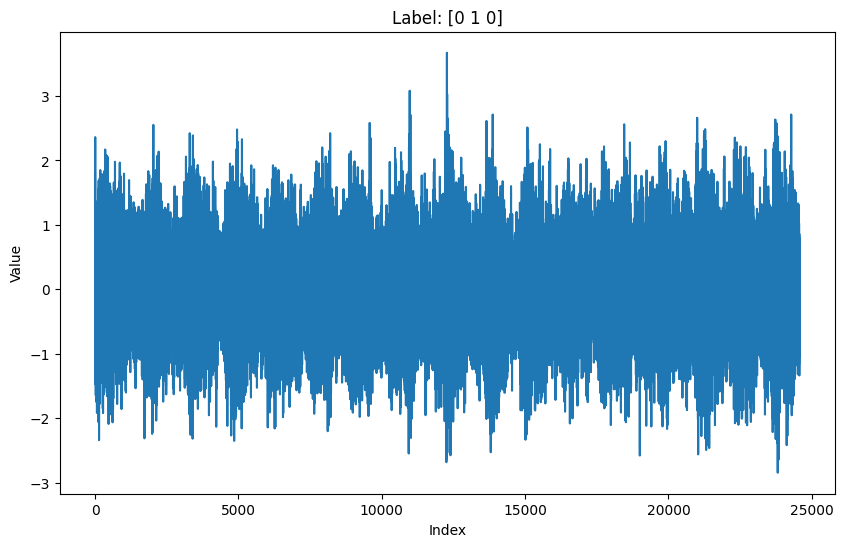

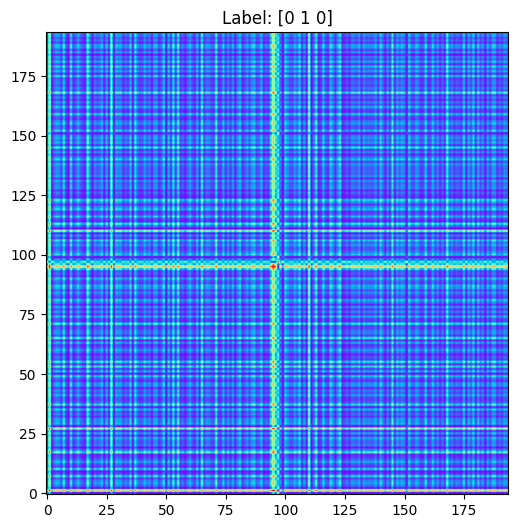

In [9]:
# Glitch Plot

y_train_label = str(y_train[0])
# Create a new figure for the glitch plot
plt.figure(figsize=(10, 6))
plt.plot(x_train[idx_train, :, 0][0])  # Adjusted the indexing based on typical data structure
plt.title(f'Label: {y_train_label}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# Create a new figure for the glitch GASF plot
plt.figure(figsize=(10, 6))
plt.imshow(img_x_train[:,0,:,:][0], cmap='rainbow', origin='lower')
plt.title(f'Label: {y_train_label}')
plt.show()


# Signal Plot

y_train_label = str(y_train[548])
# Create a new figure for the signal plot
plt.figure(figsize=(10, 6))
plt.plot(x_train[idx_train,:,0][548])
plt.title(f'Label: {y_train_label}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# Create a new figure for the signal GASF plot
plt.figure(figsize=(10, 6))
plt.imshow(img_x_train[:,0,:,:][548], cmap='rainbow', origin='lower')
plt.title(f'Label: {y_train_label}')
plt.show()


# Background Plot

y_train_label = str(y_train[55])
# Create a new figure for the Background plot
plt.figure(figsize=(10, 6))
plt.plot(x_train[idx_train,:,0][55])
plt.title(f'Label: {y_train_label}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# Create a new figure for the Background GASF plot
plt.figure(figsize=(10, 6))
plt.imshow(img_x_train[:,0,:,:][55], cmap='rainbow', origin='lower')
plt.title(f'Label: {y_train_label}')
plt.show()

In [10]:
### -------------Split into training and validation datasets------------- ###

# Assuming img_x_train is defined and has the shape (N, 2, 194, 194)
# Assuming y_train is defined and has the shape (N, 3), where N can be any integer

# Total number of samples
total_samples = img_x_train.shape[0]

# Calculate the number of samples in each dataset
num_train = int(0.8 * total_samples)  # 80% for training
num_test = int(0.15 * total_samples)  # 15% for testing
num_val = total_samples - num_train - num_test  # Remaining 5% for validation, adjusted to avoid rounding issues

# Create training, testing, and validation datasets for img_x_train
x_train_data = img_x_train[:num_train]
x_test_data = img_x_train[num_train:num_train + num_test]
x_val_data = img_x_train[num_train + num_test:]

# Create training, testing, and validation datasets for y_train
y_train_data = y_train[:num_train]
y_test_data = y_train[num_train:num_train + num_test]
y_val_data = y_train[num_train + num_test:]

# Print shapes to verify the distribution
print("Training Data Shape:", x_train_data.shape)
print("Testing Data Shape:", x_test_data.shape)
print("Validation Data Shape:", x_val_data.shape)
print("y_train Data Shape:", y_train_data.shape)
print("y_test Data Shape:", y_test_data.shape)
print("y_validation Data Shape:", y_val_data.shape)


Training Data Shape: (1600, 2, 194, 194)
Testing Data Shape: (300, 2, 194, 194)
Validation Data Shape: (100, 2, 194, 194)
y_train Data Shape: (1600, 3)
y_test Data Shape: (300, 3)
y_validation Data Shape: (100, 3)


In [11]:
strains = [x_train_data, x_test_data, x_val_data]
targets = [y_train_data, y_test_data, y_val_data]

# Collecting and printing the shape of each array
array_shapes = [arr.shape for arr in strains]
for i, shape in enumerate(array_shapes):
    print(f"Shape of strain {i}: {shape}")

array_shapes = [arr.shape for arr in targets]
for i, shape in enumerate(array_shapes):
    print(f"Shape of targets {i}: {shape}")

Shape of strain 0: (1600, 2, 194, 194)
Shape of strain 1: (300, 2, 194, 194)
Shape of strain 2: (100, 2, 194, 194)
Shape of targets 0: (1600, 3)
Shape of targets 1: (300, 3)
Shape of targets 2: (100, 3)


In [12]:
# ### -------------Load dataset------------- ###

# # Define the file name
# filename = '/home/dfredin/gwgasf/data/classify_data.h5'

# # Open the file
# with h5py.File(filename, 'r') as file:
#     # Load the datasets
#     bbh_train = np.array(file['Training']['bbh'])
#     bbh_val = np.array(file['Validation']['bbh'])
#     glitch_train = np.array(file['Training']['glitch'])
#     glitch_val = np.array(file['Validation']['glitch'])


# # Define the file name
# filename = '/home/dfredin/gwgasf/data/overlap.h5'

# # Open the file
# with h5py.File(filename, 'r') as file:
#     # Load the datasets
#     overlap = np.array(file['overlap'])
#     overlap_train = overlap[:-299]
#     overlap_val = overlap[-299:]


# ## ---------------- ONE-HOT ENCODING ----------------------------##

# # NOTE: 
# # Multiclassifier
# anomaly_class = {
#     'Glitch': [1, 0, 0],
#     'Signal': [0, 1, 0],
#     'Overlap': [0, 0, 1]
# }


# x_train = np.concatenate((glitch_train, bbh_train, overlap_train), axis=0).transpose((0,2,1))

# x_val = np.concatenate((glitch_val, bbh_val, overlap_val), axis=0).transpose((0,2,1))


# # ID our data as background, signal or overlap

# glitch_train_ids = np.full((glitch_train.shape[0], 3), anomaly_class['Glitch'])
# bbh_train_ids = np.full((bbh_train.shape[0], 3), anomaly_class['Signal'])
# overlap_train_ids = np.full((overlap_train.shape[0], 3), anomaly_class['Overlap'])

# y_train = np.concatenate((glitch_train_ids, bbh_train_ids, overlap_train_ids), axis=0)

# glitch_val_ids = np.full((glitch_val.shape[0], 3), anomaly_class['Glitch'])
# bbh_val_ids = np.full((bbh_val.shape[0], 3), anomaly_class['Signal'])
# overlap_val_ids = np.full((overlap_val.shape[0], 3), anomaly_class['Overlap'])

# y_val = np.concatenate((glitch_val_ids, bbh_val_ids, overlap_val_ids), axis=0)


# del glitch_train, bbh_train, overlap_train, glitch_val, bbh_val, overlap_val
# del glitch_train_ids, bbh_train_ids, overlap_train_ids, glitch_val_ids, bbh_val_ids, overlap_val_ids

### -------------Split detector dataset------------- ###

# x_train_dec1 = x_train[:,:,0]
# x_train_dec2 = x_train[:,:,1]

# x_val_dec1 = x_val[:,:,0]
# x_val_dec2 = x_val[:,:,1]


# print(f'validation:{len(y_val)}')
# n_train = 10000
# n_val = 2000

# # Generate the idx_train, idx_val to randomly sample from the training set and validation set.
# idx_train = np.random.randint(0, len(x_train), size=n_train)
# idx_val = np.random.randint(0, len(x_val), size=n_val)

# x_train_dec1 = x_train[idx_train,:,0]
# x_train_dec2 = x_train[idx_train,:,1]

# y_train = y_train[idx_train]

# x_val_dec1 = x_val[idx_val,:,0]
# x_val_dec2 = x_val[idx_val,:,1]

# y_val = y_val[idx_val]

# ### -------------GASF CONVERSION------------- ###

# GASF = GramianAngularField(image_size=194, sample_range = (-1,1), method="summation")
# # Convert training data to image format
# img_x_train_dec1 = GASF.transform(x_train_dec1)
# img_x_train_dec2 = GASF.transform(x_train_dec2)
# del x_train_dec1, x_train_dec2

# # Convert testing data to image format
# img_x_val_dec1 = GASF.transform(x_val_dec1)
# img_x_val_dec2 = GASF.transform(x_val_dec2)
# del x_val_dec1, x_val_dec2


# # Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
# img_x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
# del img_x_train_dec1, img_x_train_dec2
# img_x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)
# del img_x_val_dec1, img_x_val_dec2

# img_y_val = y_val

# ### -------------Split into training and validation datasets------------- ###

# ## NOTE: MAYBE USER INPUT FOR SPLIT %???

# # Take the first 17.65% of our training features and targets as validation set
# img_x_test= img_x_train[:round((len(img_x_train)*0.12))]
# img_y_test = y_train[:round((len(y_train)*0.12))]

# # Take the remaining 82.35% of training features and targets as training set
# img_x_train = img_x_train[round((len(img_x_train)*0.12)):]
# img_y_train = y_train[round((len(y_train)*0.12)):]

# # Check the shapes of the training/validation datasets. Turns out we get about a 85%, 12%, 3% split.
# print("X Training Shape: ", img_x_train.shape)
# print("Y Training Shape: ", img_y_train.shape)
# print("X Testing Shape: ", img_x_test.shape)
# print("Y Testing Shape: ", img_y_test.shape)
# print("X Validation Shape: ", img_x_val.shape)
# print("Y Validation Shape: ", img_y_val.shape)


# strains = [img_x_train, img_x_val, img_x_test]

# # strains = [training_strain, validation_strain, testing_strain]

# targets = [img_y_train, img_y_val, img_y_test]

# # targets = [training_targets, validation_targets, testing_targets]

## DataLoader

In [13]:
class MyDataset(Dataset):

    def __init__(self, data, target, ifos=3, kernel_size=4096):

        # Get data type from https://pytorch.org/docs/stable/tensors.html
        # self.data = torch.FloatTensor(
        #     data.reshape([-1, ifos, kernel_size])
        # )
        # 
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(target)
    
    def __len__(self):
        
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        return x, y

In [14]:
# Load Training data into pytorch tensor
dataset = MyDataset(strains[0], targets[0])
training_data = DataLoader(
    dataset, 
    batch_size=32, 
    shuffle=True
)

# Load testing data into pytorch tensor
dataset_t = MyDataset(strains[2], targets[2])
testing_data = DataLoader(
    dataset_t, 
    batch_size=32, 
    shuffle=True
)


# Load Validation data into pytorch tensor
dataset_v = MyDataset(strains[1], targets[1])
validation_data = DataLoader(
    dataset_v, 
    batch_size=32, 
    shuffle=True
)

## CNN Model

In [15]:

               ## # | 64 x 64 | 127 x 127 | 194 x 194 |
cnn1In = 2     ## # |    2    |     2     |     2     |
cnn1Out = 64   ## # |    16   |     16    |     16    |    
cnn1K = 6      ## # |    4    |     5     |     6     |
cnn1S = 2      ## # |    2    |     2     |     2     |
cnn1P = 1      ## # |    1    |     2     |     1     |
batch1 = 64    ## # |    16   |     16    |     16    |
max1K = 5      ## # |    4    |     2     |     5     |
max1S = 3      ## # |    2    |     2     |     3     |
max1P = 1      ## # |    1    |     0     |     1     |

cnn2In = 64    ## # |    16   |     16    |     16    |
cnn2Out = 128   ## # |    32   |     32    |     32    |
cnn2K = 4      ## # |    3    |     4     |     4     |
cnn2S = 2      ## # |    1    |     2     |     2     |
cnn2P = 1      ## # |    1    |     1     |     1     |
batch2 = 128    ## # |    32   |     32    |     32    |
max2K = 2      ## # |    2    |     2     |     2     |
max2S = 2      ## # |    2    |     2     |     2     |
max2P = 0      ## # |    0    |     0     |     0     |

### -------------194 x 194 Model Definition------------- ###

class CNNModel(nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

                # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=cnn1Out, kernel_size=cnn1K, stride=cnn1S, padding=cnn1P),
            nn.ReLU(),
            nn.BatchNorm2d(batch1),
            nn.MaxPool2d(kernel_size=max1K, stride=max1S, padding=max1P)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=cnn2In, out_channels=cnn2Out, kernel_size=cnn2K, stride=cnn2S, padding=cnn2P),
            nn.ReLU(),
            nn.BatchNorm2d(batch2),
            nn.MaxPool2d(kernel_size=max2K, stride=max2S, padding=max2P)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 8 ,8) -> (2048) and output 2 classes
        self.fc1 = nn.Linear(in_features=128*8*8, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=3)
        self.dropcnn = nn.Dropout(0.25)
        self.dropfc = nn.Dropout(0.6)

    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        out = self.dropcnn(out)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        out = self.dropcnn(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.dropfc(out)
        out = self.fc2(out)
        out = self.dropfc(out)
        out = self.fc3(out)
        
        return out

## Hyperparameters

In [16]:
  ### -------------Hyperparameters------------- ###

# Initialize the CNN model
GASF_Model = CNNModel().to(device)

# An easy way to give you the outline of your model
summary(GASF_Model,  (2, 194, 194), len(strains[0]))

learning_rate = 0.0005     # 0.00005
epochs = 25                 # 40
# batchsize = 225             # 768
L2_reg = 0.001            # 0.00005

# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    GASF_Model.parameters(), 
    lr = learning_rate, 
    weight_decay=L2_reg)

/home/dfredin/miniconda3/envs/GASF39/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1600, 64, 96, 96]           4,672
              ReLU-2         [1600, 64, 96, 96]               0
       BatchNorm2d-3         [1600, 64, 96, 96]             128
         MaxPool2d-4         [1600, 64, 32, 32]               0
           Dropout-5         [1600, 64, 32, 32]               0
            Conv2d-6        [1600, 128, 16, 16]         131,200
              ReLU-7        [1600, 128, 16, 16]               0
       BatchNorm2d-8        [1600, 128, 16, 16]             256
         MaxPool2d-9          [1600, 128, 8, 8]               0
          Dropout-10          [1600, 128, 8, 8]               0
           Linear-11               [1600, 1024]       8,389,632
          Dropout-12               [1600, 1024]               0
           Linear-13                [1600, 512]         524,800
          Dropout-14                [16

## Training

In [17]:
cost_value = np.empty(epochs)
cost_valid_value = np.empty(epochs)

for i in range(epochs):
    t_cost = 0
    for j, (x, y) in enumerate(tqdm(training_data, desc=f'Epoch {i+1}')):
        x = x.to(device)
        y = y.to(device)
        # print(y)

        p_value = GASF_Model(x)

        p_value = torch.transpose(p_value,0,1)
        y = torch.transpose(y,0,1)
        # print(p_value)
        y = torch.argmax(y, dim = 1)
        cost = loss_func(p_value, y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
        t_cost += cost.item()

    cost_value[i] = t_cost/(j+1)
        
    print('========')
    print(f'Cost{round(cost_value[i], 2)}')
    print('========', '\n')

    with torch.no_grad():
        v_cost = 0
        for run, (a, b) in enumerate(validation_data):
            a = a.to(device)
            b = b.to(device)
            
            p_value = GASF_Model(a)

            p_value = torch.transpose(p_value,0,1)
            b = torch.transpose(b,0,1)

            b = torch.argmax(b, dim = 1)
            cost_valid = loss_func(p_value, b)
            
            v_cost += cost_valid.item()
            
        cost_valid_value[i] = v_cost/(run+1)
        
        print('===================')
        print(f'Validation Cost{round(cost_valid_value[i], 2)}')
        print('===================', '\n')

Epoch 1: 100%|██████████| 50/50 [00:02<00:00, 20.19it/s]


Cost9.49

Validation Cost8.96



Epoch 2: 100%|██████████| 50/50 [00:02<00:00, 23.15it/s]


Cost9.16

Validation Cost7.32



Epoch 3: 100%|██████████| 50/50 [00:02<00:00, 23.16it/s]


Cost7.1

Validation Cost6.59



Epoch 4: 100%|██████████| 50/50 [00:02<00:00, 23.50it/s]


Cost8.04

Validation Cost6.66



Epoch 5: 100%|██████████| 50/50 [00:02<00:00, 23.08it/s]


Cost7.29

Validation Cost5.8



Epoch 6: 100%|██████████| 50/50 [00:02<00:00, 23.36it/s]


Cost5.24

Validation Cost5.39



Epoch 7: 100%|██████████| 50/50 [00:02<00:00, 22.78it/s]


Cost4.93

Validation Cost4.98



Epoch 8: 100%|██████████| 50/50 [00:02<00:00, 23.43it/s]


Cost4.84

Validation Cost4.32



Epoch 9: 100%|██████████| 50/50 [00:02<00:00, 23.44it/s]


Cost4.33

Validation Cost4.08



Epoch 10: 100%|██████████| 50/50 [00:02<00:00, 23.42it/s]


Cost4.17

Validation Cost4.27



Epoch 11: 100%|██████████| 50/50 [00:02<00:00, 23.23it/s]


Cost4.1

Validation Cost4.39



Epoch 12: 100%|██████████| 50/50 [00:02<00:00, 23.18it/s]


Cost4.14

Validation Cost4.04



Epoch 13: 100%|██████████| 50/50 [00:02<00:00, 23.33it/s]


Cost3.7

Validation Cost4.72



Epoch 14: 100%|██████████| 50/50 [00:02<00:00, 23.07it/s]


Cost3.9

Validation Cost3.47



Epoch 15: 100%|██████████| 50/50 [00:02<00:00, 23.54it/s]


Cost3.98

Validation Cost3.45



Epoch 16: 100%|██████████| 50/50 [00:02<00:00, 23.55it/s]


Cost3.27

Validation Cost3.68



Epoch 17: 100%|██████████| 50/50 [00:02<00:00, 22.72it/s]


Cost3.51

Validation Cost3.7



Epoch 18: 100%|██████████| 50/50 [00:02<00:00, 22.78it/s]


Cost3.39

Validation Cost3.46



Epoch 19: 100%|██████████| 50/50 [00:02<00:00, 23.34it/s]


Cost3.39

Validation Cost3.64



Epoch 20: 100%|██████████| 50/50 [00:02<00:00, 23.45it/s]


Cost3.43

Validation Cost3.55



Epoch 21: 100%|██████████| 50/50 [00:02<00:00, 23.61it/s]


Cost3.07

Validation Cost3.24



Epoch 22: 100%|██████████| 50/50 [00:02<00:00, 22.91it/s]


Cost3.23

Validation Cost3.46



Epoch 23: 100%|██████████| 50/50 [00:02<00:00, 23.61it/s]


Cost3.24

Validation Cost3.17



Epoch 24: 100%|██████████| 50/50 [00:02<00:00, 23.34it/s]


Cost3.27

Validation Cost3.37



Epoch 25: 100%|██████████| 50/50 [00:02<00:00, 23.56it/s]


Cost3.08

Validation Cost3.26



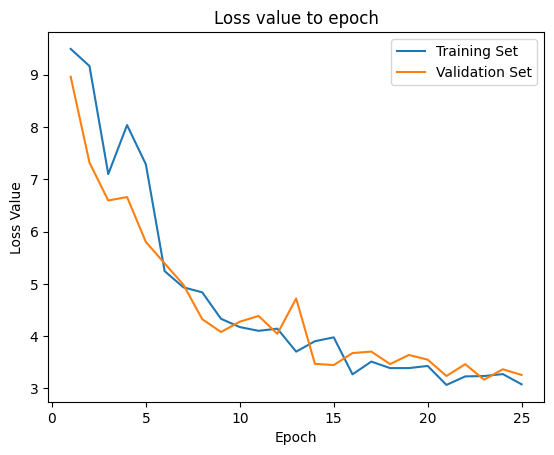

In [18]:
total_epoch = np.linspace(1, epochs, epochs)
plt.title('Loss value to epoch')
plt.plot(total_epoch, cost_value, label = 'Training Set')
plt.plot(total_epoch, cost_valid_value, label = 'Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
train_val_Lossplot_filename = '/home/dfredin/gwgasf/results/figures/train_val_Loss.png'
plt.savefig(train_val_Lossplot_filename, bbox_inches = 'tight')
plt.show()
plt.close()

-------

## Confusion Matrix Analysis

In [19]:
# torch tensor device check

if device.type == 'cpu':
    dtype = torch.FloatTensor
elif device.type =='cuda':
    dtype = torch.cuda.FloatTensor

100%|██████████| 10/10 [00:00<00:00, 60.68it/s]


tensor([  7., 133., 160.], device='cuda:0')
Precision: 0.6040570175438597
Recall: 0.6040570175438597
F1 Score: 0.6040570175438597


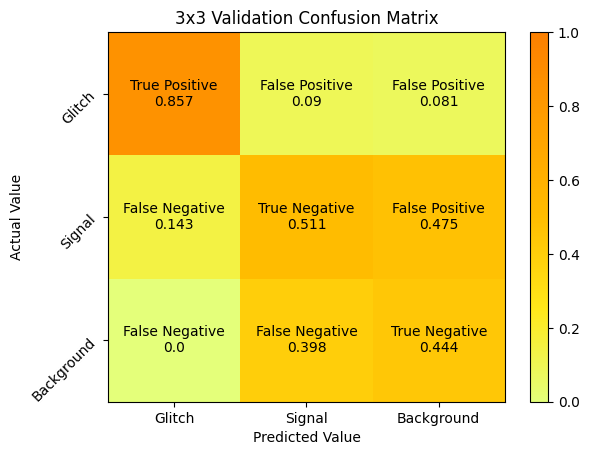

100%|██████████| 50/50 [00:00<00:00, 60.16it/s]


tensor([ 64., 757., 779.], device='cuda:0')
Precision: 0.6906995449404191
Recall: 0.6906995449404192
F1 Score: 0.6906995449404191


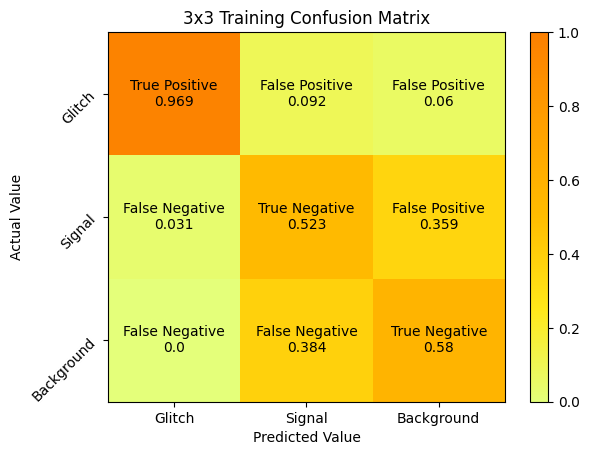

100%|██████████| 4/4 [00:00<00:00, 59.85it/s]


tensor([ 9., 44., 47.], device='cuda:0')
Precision: 0.6770542302457195
Recall: 0.6770542302457195
F1 Score: 0.6770542302457195


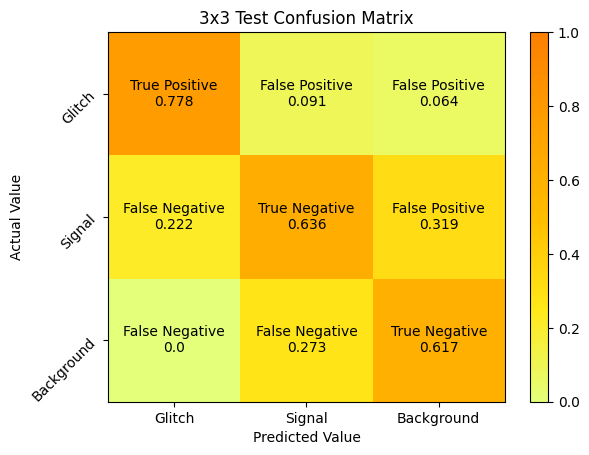

In [20]:
def calculate_metrics(conf_matrix):
    # Calculate precision, recall, and F1 score for the entire model
    TP = np.sum(np.diag(conf_matrix))  # True Positives
    FP = np.sum(np.sum(conf_matrix, axis=0) - np.diag(conf_matrix))  # False Positives
    FN = np.sum(np.sum(conf_matrix, axis=1) - np.diag(conf_matrix))  # False Negatives

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

def plot_confusion_matrix(data, title):
    num_classes = 3
    conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
    num_count = torch.zeros([num_classes]).to(device)

    with torch.no_grad():
        for num, (x, y) in enumerate(tqdm(data)):
            Real_label = y.to(device)

            # Convert sofmax output to onehot
            max_class = torch.Tensor.argmax(GASF_Model(x.to(device)), axis=1)
            pred = F.one_hot(max_class)

            # Accumlating statical value
            conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
            num_count += Real_label.sum(axis=0)

        print(num_count)
        num_count = num_count.detach().cpu().numpy().astype('float64')
        conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    # Normalize the confusion matrix.
    conf_matrix /= num_count

    precision, recall, f1_score = calculate_metrics(conf_matrix)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1_score}')

    # Labels for a 3x3 confusion matrix
    lab = np.array([['True Positive', 'False Positive', 'False Positive'], 
                    ['False Negative', 'True Negative', 'False Positive'],
                    ['False Negative', 'False Negative', 'True Negative']])

    plt.figure()
    color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

    # Adjust the loop for a 3x3 matrix
    for i in range(3):
        for j in range(3):
            plt.text(i+.5, j+.5, 
                     f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
                     ha='center', 
                     va='center')

    # Update the ticks for three classes
    plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Background'])
    plt.yticks([.5, 1.5, 2.5], ['Background', 'Signal', 'Glitch'], rotation=45)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title(f'3x3 {title} Confusion Matrix')
    plt.colorbar(color)
    plt.savefig(f'/home/dfredin/gwgasf/results/figures/{title}_confuMatrix.png', bbox_inches = 'tight')
    plt.show()
    plt.close()

# Call the function for each of your datasets
plot_confusion_matrix(validation_data, 'Validation')
plot_confusion_matrix(training_data, 'Training')
plot_confusion_matrix(testing_data, 'Test')

In [ ]:
# num_classes = 3
# conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
# num_count = torch.zeros([num_classes]).to(device)

# with torch.no_grad():
#     for num, (x, y) in enumerate(tqdm(validation_data)):
        
#         Real_label = y.to(device)

#         # Convert sofmax output to onehot
#         max_class = torch.Tensor.argmax(GASF_Model(x.to(device)), axis=1)
#         pred = F.one_hot(max_class)

#         # Accumlating statical value
#         conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
#         num_count += Real_label.sum(axis=0)

#     print(num_count)
#     num_count = num_count.detach().cpu().numpy().astype('float64')
#     conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    
# # Normalize the confusion matrix.
# conf_matrix /= num_count

# # print(conf_matrix)

# # TODO Old confusion matrix code, not needed?
# # Plotting Scheme
# # TPR = conf_matrix[0, 0]
# # FPR = conf_matrix[0,1]/(conf_matrix[0,0] + conf_matrix[0,1])

   
# # print(f'TPR: {TPR}')
# # print(f'FPR: {FPR}')

# # Labels for a 3x3 confusion matrix
# lab = np.array([['True Positive', 'False Positive', 'False Positive'], 
#                 ['False Negative', 'True Negative', 'False Positive'],
#                 ['False Negative', 'False Negative', 'True Negative']])

# plt.figure()
# color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

# # Adjust the loop for a 3x3 matrix
# for i in range(3):
#     for j in range(3):
#         plt.text(i+.5, j+.5, 
#                  f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
#                  ha='center', 
#                  va='center')

# # Update the ticks for three classes
# plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Background'])
# plt.yticks([.5, 1.5, 2.5], ['Background', 'Signal', 'Glitch'], rotation=45)
# plt.xlabel('Predicted Value')
# plt.ylabel('Actual Value')
# plt.title('3x3 Validation Confusion Matrix')
# # plt.title(
# #     f'Training set with:     TPR: {round(conf_matrix[0, 0], 3)}FAR: {round(FPR, 3)}'
# # )
# plt.colorbar(color)
# val_confuMatrix_filename = '/home/dfredin/gwgasf/results/figures/val_confuMatrix.png'
# plt.savefig(val_confuMatrix_filename, bbox_inches = 'tight')
# plt.show()
# plt.close()


In [ ]:
# num_classes = 3
# conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
# num_count = torch.zeros([num_classes]).to(device)

# with torch.no_grad():
#     for num, (x, y) in enumerate(tqdm(training_data)):
        
#         Real_label = y.to(device)

#         # Convert sofmax output to onehot
#         max_class = torch.Tensor.argmax(GASF_Model(x.to(device)), axis=1)
#         pred = F.one_hot(max_class)

#         # Accumlating statical value
#         conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
#         num_count += Real_label.sum(axis=0)

#     print(num_count)
#     num_count = num_count.detach().cpu().numpy().astype('float64')
#     conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    
# # Normalize the confusion matrix.
# conf_matrix /= num_count

# # print(conf_matrix)

# # TODO Old confusion matrix code, not needed?
# # Plotting Scheme
# # TPR = conf_matrix[0, 0]
# # FPR = conf_matrix[0,1]/(conf_matrix[0,0] + conf_matrix[0,1])

   
# # print(f'TPR: {TPR}')
# # print(f'FPR: {FPR}')

# # Labels for a 3x3 confusion matrix
# lab = np.array([['True Positive', 'False Positive', 'False Positive'], 
#                 ['False Negative', 'True Negative', 'False Positive'],
#                 ['False Negative', 'False Negative', 'True Negative']])

# plt.figure()
# color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

# # Adjust the loop for a 3x3 matrix
# for i in range(3):
#     for j in range(3):
#         plt.text(i+.5, j+.5, 
#                  f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
#                  ha='center', 
#                  va='center')

# # Update the ticks for three classes
# plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Background'])
# plt.yticks([.5, 1.5, 2.5], ['Background', 'Signal', 'Glitch'], rotation=45)
# plt.xlabel('Predicted Value')
# plt.ylabel('Actual Value')
# plt.title('3x3 Training Confusion Matrix')
# # plt.title(
# #     f'Training set with:     TPR: {round(conf_matrix[0, 0], 3)}FAR: {round(FPR, 3)}'
# # )
# plt.colorbar(color)
# train_confuMatrix_filename = '/home/dfredin/gwgasf/results/figures/train_confuMatrix.png'
# plt.savefig(train_confuMatrix_filename, bbox_inches = 'tight')
# plt.show()
# plt.close()


In [ ]:
# num_classes = 3
# conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
# num_count = torch.zeros([num_classes]).to(device)

# with torch.no_grad():
#     for num, (x, y) in enumerate(tqdm(testing_data)):
        
#         Real_label = y.to(device)

#         # Convert sofmax output to onehot
#         max_class = torch.Tensor.argmax(GASF_Model(x.to(device)), axis=1)
#         pred = F.one_hot(max_class)

#         # Accumlating statical value
#         conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
#         num_count += Real_label.sum(axis=0)

#     print(num_count)
#     num_count = num_count.detach().cpu().numpy().astype('float64')
#     conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    
# # Normalize the confusion matrix.
# conf_matrix /= num_count

# # print(conf_matrix)

# # TODO Old confusion matrix code, not needed?
# # Plotting Scheme
# # TPR = conf_matrix[0, 0]
# # FPR = conf_matrix[0,1]/(conf_matrix[0,0] + conf_matrix[0,1])

   
# # print(f'TPR: {TPR}')
# # print(f'FPR: {FPR}')

# # Labels for a 3x3 confusion matrix
# lab = np.array([['True Positive', 'False Positive', 'False Positive'], 
#                 ['False Negative', 'True Negative', 'False Positive'],
#                 ['False Negative', 'False Negative', 'True Negative']])

# plt.figure()
# color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

# # Adjust the loop for a 3x3 matrix
# for i in range(3):
#     for j in range(3):
#         plt.text(i+.5, j+.5, 
#                  f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
#                  ha='center', 
#                  va='center')

# # Update the ticks for three classes
# plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Background'])
# plt.yticks([.5, 1.5, 2.5], ['Background', 'Signal', 'Glitch'], rotation=45)
# plt.xlabel('Predicted Value')
# plt.ylabel('Actual Value')
# plt.title('3x3 Testing Confusion Matrix')
# # plt.title(
# #     f'Training set with:     TPR: {round(conf_matrix[0, 0], 3)}FAR: {round(FPR, 3)}'
# # )
# plt.colorbar(color)
# test_confuMatrix_filename = '/home/dfredin/gwgasf/results/figures/test_confuMatrix.png'
# plt.savefig(test_confuMatrix_filename, bbox_inches = 'tight')
# plt.show()
# plt.close()
